 __Importar las librerias que voy a utilizar para analizar el Dataset__

In [2]:
# Librerias para analisis, algebra, visualización y transformación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_summary import DataFrameSummary
from os import path

__Librerias necesarias a instalar:__

In [3]:
# pip install contractions

In [4]:
# pip install pyLDAvis

In [5]:
# pip install fasttext

In [6]:
# pip install gensim

__Importar las librerias requeridas__

In [7]:
import nltk
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
from nltk import FreqDist
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim import models
import gensim
import pyLDAvis
from pyLDAvis.gensim_models import prepare
pyLDAvis.enable_notebook()
from collections import Counter

__Cargar el DataSet__

In [8]:
df = pd.read_csv('../data/raw/file_name.csv')

In [9]:
df.head(2)

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09


In [10]:
data_summary = DataFrameSummary(df)
data_summary.columns_stats.T

,counts,uniques,missing,missing_perc,types
Title,12854,12324,0,0%,categorical
Political Lean,12854,2,0,0%,bool
Score,12854,974,0,0%,numeric
Id,12854,12854,0,0%,unique
Subreddit,12854,15,0,0%,categorical
URL,12854,12327,0,0%,categorical
Num of Comments,12854,312,0,0%,numeric
Text,2428,2390,10426,81.11%,categorical
Date Created,12854,12833,0,0%,numeric


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854 entries, 0 to 12853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            12854 non-null  object 
 1   Political Lean   12854 non-null  object 
 2   Score            12854 non-null  int64  
 3   Id               12854 non-null  object 
 4   Subreddit        12854 non-null  object 
 5   URL              12854 non-null  object 
 6   Num of Comments  12854 non-null  int64  
 7   Text             2428 non-null   object 
 8   Date Created     12854 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 903.9+ KB


In [12]:
# La columna Text tiene solo 2428 valores, el resto son null

In [13]:
# Paso las columnas a minusculas por comodidad
df.columns= df.columns.str.lower()

__Elimino las columnas inutiles como ID y Date Created__

In [14]:
df.drop(['id', 'date created'], axis =1, inplace = True)

__Variable a predecir Political Lean__

In [15]:
df['political lean'].unique()

array(['Liberal', 'Conservative'], dtype=object)

In [16]:
colors = {'Liberal':'red',
        'Conservative':'blue'}

## __1. EDA__

C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


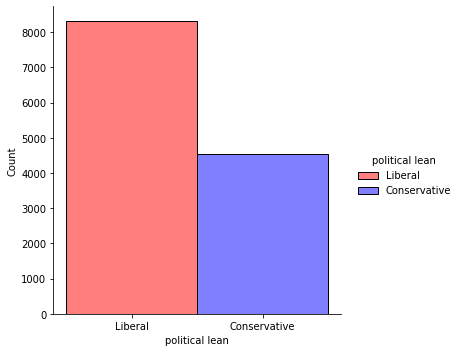

In [17]:
sns.displot(data=df, x="political lean", 
            palette=colors, hue="political lean", kde=True);


In [18]:
color = ('#E16666','#6682E1')
labels = ['Liberal','Conservative']

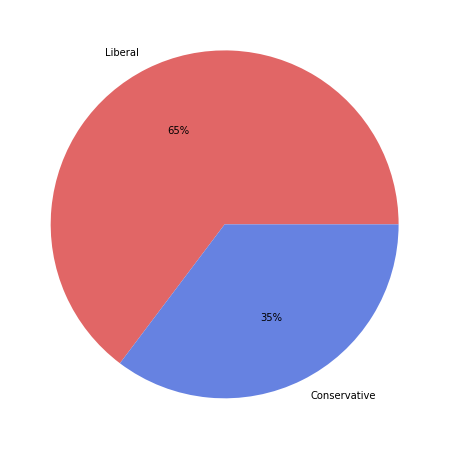

In [19]:
plt.figure(figsize=(8,8))
plt.pie(df['political lean'].value_counts(),labels=labels, colors=color ,autopct = '%0.0f%%')
plt.show()

Viendo que la variable target tiene una distribución desbalanceada, y al ser un modelo de clasificación. Utilizare arboles de decisión para entrenar el modelo.

Columna Subreddit

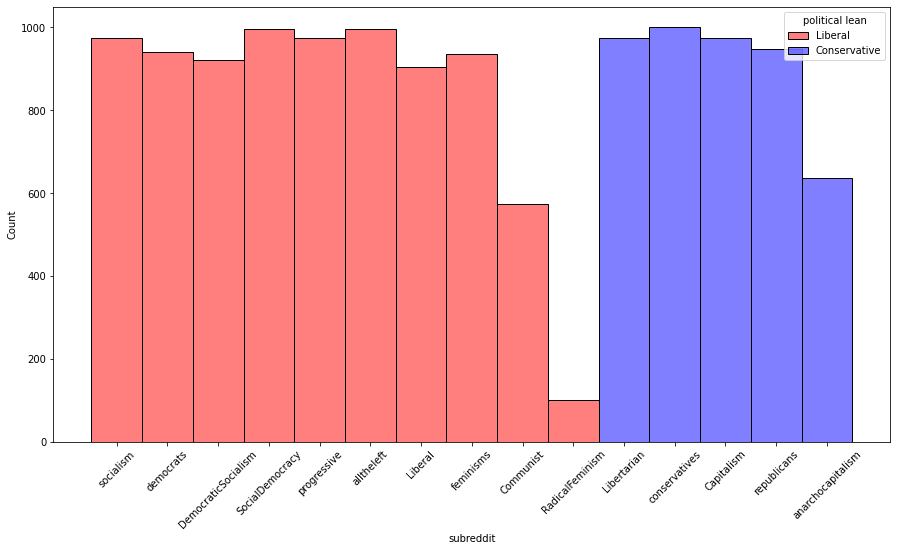

In [20]:
plt.figure(figsize = (15,8))
ax = sns.histplot(data=df,x='subreddit', hue='political lean',palette=colors)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

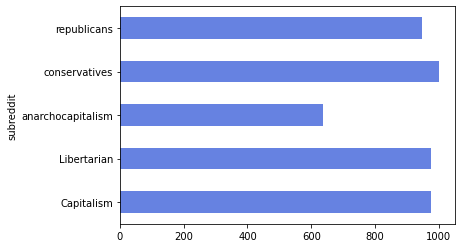

In [21]:
df_temp = df.loc[df['political lean'] == 'Conservative'].reset_index(drop=True)
df_temp.groupby('subreddit')['political lean'].count().plot(kind= 'barh', color='#6682E1');

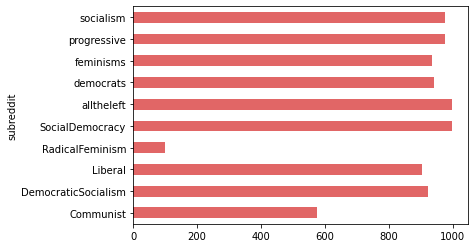

In [22]:
df_temp = df.loc[df['political lean'] == 'Liberal'].reset_index(drop=True)
df_temp.groupby('subreddit')['political lean'].count().plot(kind= 'barh', color='#E16666');

Columna score

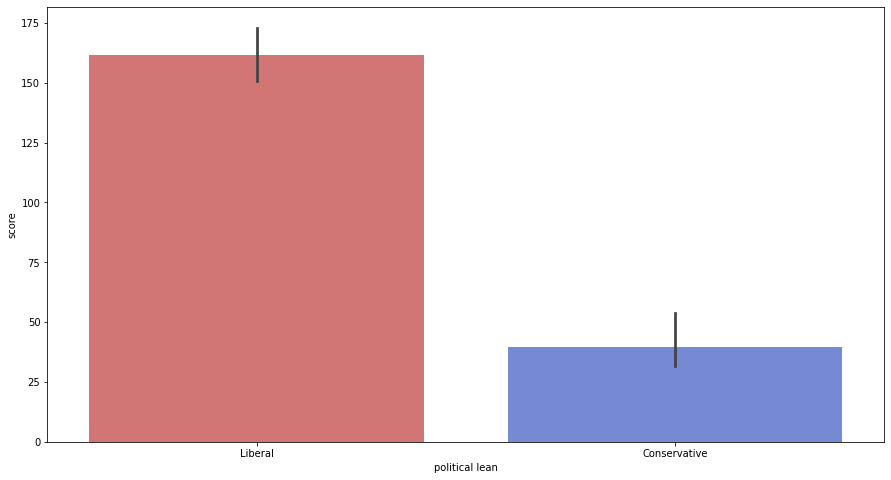

In [23]:
plt.figure(figsize = (15,8))
sns.barplot(y=df['score'],x=df['political lean'], palette=color);

### __Columnas de texto__ : Procesamiento

In [35]:
'''
    Libreria Regex necesaria, Import re
    Función para procesar textos en ingles,
    ingresas el texto y sale limpio
'''

def process_text(text):
    
    #tokenize the text
    text = word_tokenize(text)
    
    #Expand contractions 
    text = [contractions.fix(word) for word in text]
    
    #only alphabets
    text = [ re.sub('[^A-Za-z]+', '', word) for word in text]
    
    #lowercase
    text = [word.lower() for word in text if word.isalpha()]
    
    #stopwords
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    
    #Lemmatizer
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    
    text = ' '.join(text)
    return text

__Columna URL__

Esta columna es distinta a las demás de texto, voy a quedarme solo con las webs

In [25]:
df['url'] = df['url'].apply(lambda x: x.replace('https://',''))
df['url'] = df['url'].apply(lambda x: x.replace('http://',''))
df['url'] = df['url'].apply(lambda x: x.replace('/','.'))

In [26]:
df['url'] = df['url'].str.split('.')

In [27]:
webs = []

In [28]:
def urls():
    for i in df['url']:
        webs.append(i[0:2])
urls()

In [29]:
webs_2 = []

In [30]:
def add():
    for i in webs:
        webs_2.append('.'.join(i))
add()

In [31]:
df['webs'] = webs_2

In [32]:
df['webs'] = df['webs'].str.replace('www.','')
df['webs'] = df['webs'].str.replace('.org','')
df['webs'] = df['webs'].str.replace('.com','')
df['webs'] = df['webs'].str.replace('.net','')
df['webs'] = df['webs'].str.replace('i.redd','reddit')
df['webs'] = df['webs'].str.replace('.','')

C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
C:\Users\Carmelo\AppData\Local\Programs\Python\Python

In [33]:
df['webs'].value_counts()

reddit            4075
youtube            889
washingtonpost     275
nytimes            266
cnn                210
                  ... 
theirisnyc           1
pairagraph           1
prescottenews        1
newsthump            1
wikimises            1
Name: webs, Length: 1719, dtype: int64

In [36]:
df['webs'] = df['webs'].apply(process_text)

In [37]:
lista = []
for word in df['webs']:
    lista.append(word)

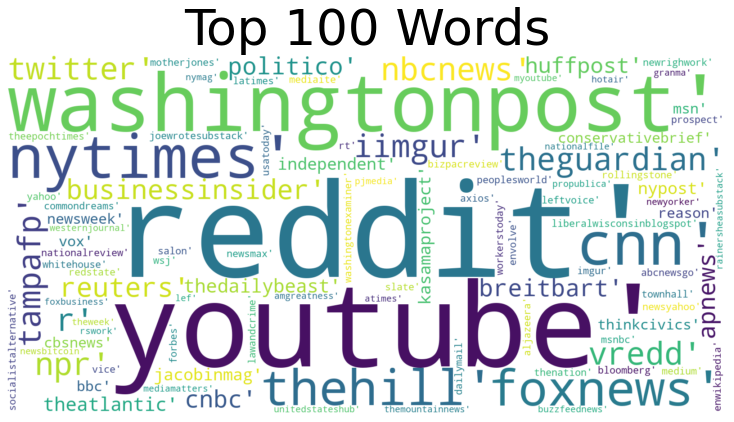

In [40]:
def top100plot(lista):    
    mostcommon = FreqDist(lista).most_common(100)
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
    plt.figure(figsize=(10,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Top 100 Words', fontsize=50)
    plt.tight_layout(pad=0)
    return plt.show()

top100plot(lista)

In [ ]:
df.drop(columns='url',inplace=True)

__Columna Text__

In [ ]:
df['text'].fillna('', inplace=True)

In [ ]:
df['text'] = df['text'].apply(process_text)

In [ ]:
lista = []
for word in df['text']:
    lista.append(word)

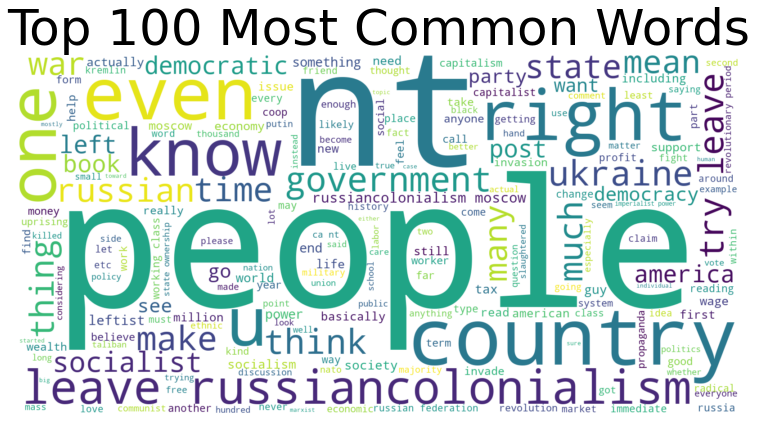

In [ ]:
mostcommon = FreqDist(lista).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

__Columna Title__

In [ ]:
df['title'] = df['title'].apply(process_text)

In [ ]:
lista = []
for word in df['title']:
    lista.append(word)

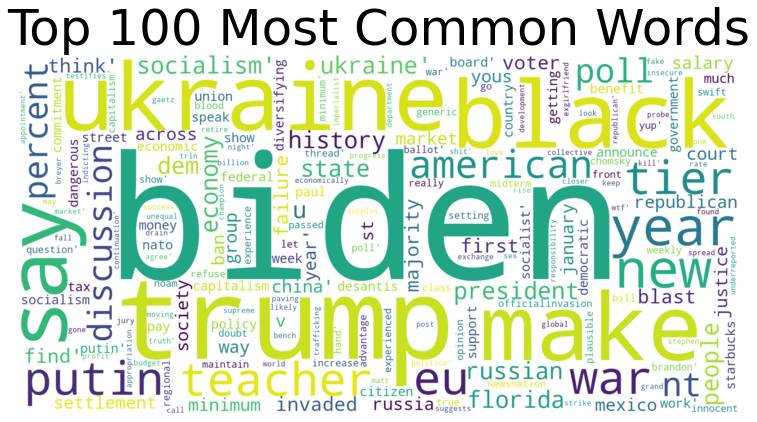

In [ ]:
mostcommon = FreqDist(lista).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

### __Analisis de Texto__

Columna title:

In [ ]:

def get_top_ngram(corpus, n): # Entrada, cuerpo del texto, y numero de palabras frecuentes
    
    '''
    Función para conseguir el 
    numero de palabras mas frecuentes
    '''

    lis=[]
    vec = CountVectorizer(ngram_range = (n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    for word,idx in vec.vocabulary_.items():
        lis.append((word, sum_words[0,idx]))
    lis.sort(key = lambda x: x[1], reverse = True)
    return lis    

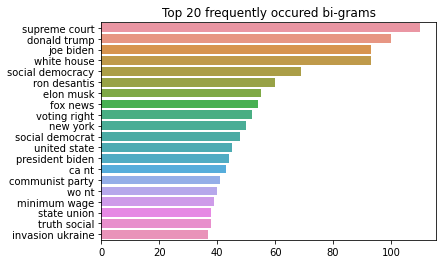

In [ ]:
# Top dos clave
top_n_bigrams=get_top_ngram(df['title'],2)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured bi-grams')
sns.barplot(x=y,y=x);

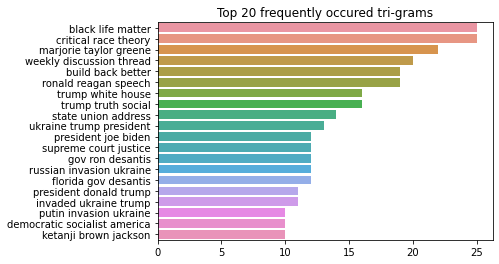

In [ ]:
# Top tres palabras
top_n_bigrams=get_top_ngram(df['title'],3)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured tri-grams')
sns.barplot(x=y,y=x);

Columna text, utilizo esta columna solo para ver el contexto de las frases mas repetidas, pero al tener tantos NaN, no la utilizare.

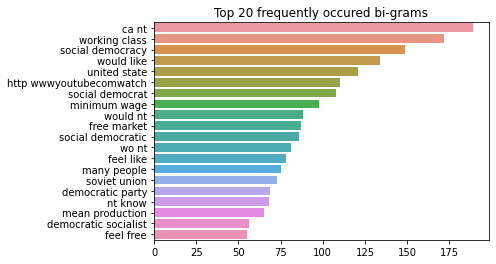

In [ ]:
# Top dos clave
top_n_bigrams=get_top_ngram(df['text'],2)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured bi-grams')
sns.barplot(x=y,y=x);

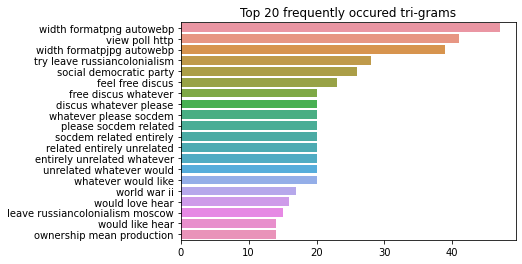

In [ ]:
# Top tres palabras
top_n_bigrams=get_top_ngram(df['text'],3)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured tri-grams')
sns.barplot(x=y,y=x);

## __2. Feature Engineering__

Creo un nuevo dataframe solo con las columnas title y la target, para hacer un modelo de predicción solo con esta columna

In [ ]:
df = df[['title','political lean']]

KeyError: "['political lean'] not in index"

In [ ]:
# Convierto la columna de political lean a int y le cambio el nombre a target por comodidad
df['political lean'] = df['political lean'].apply(lambda x: 1 if x=='Liberal' else 0)

KeyError: 'political lean'

In [ ]:
df = pd.read_csv('../data/raw/file_name.csv')
df.columns= df.columns.str.lower()

In [ ]:
df.rename(columns={'political lean':'target'}, inplace=True)

In [ ]:
df['target'] = df['target'].apply(lambda x: 1 if x=='Liberal' else 0)

## __3. Creación del modelo__

In [ ]:
import regex as re

In [ ]:
features = df['title']
labels = df.target.values

In [ ]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # Remove all single characters
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    
    # Remove multiple spaces with single space
    processed_feature = re.sub(r'\s+', '', processed_feature)

    # Remove prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    
    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer ()

processed_features = vectorizer.fit_transform(processed_features)

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
df.target.unique()

array([1, 0], dtype=int64)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=45)

In [ ]:
pd.DataFrame(X_train)

,0
0,"(0, 3896)\t1.0"
1,"(0, 11260)\t1.0"
2,"(0, 5004)\t1.0"
3,"(0, 10614)\t1.0"
4,"(0, 7113)\t1.0"
...,...
10278,"(0, 7646)\t1.0"
10279,"(0, 2837)\t1.0"
10280,"(0, 3942)\t1.0"
10281,"(0, 7031)\t1.0"


#### __Grid Search, Logistic Regresor, RandomForest, Support Vector Machine__

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
'''for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)'''

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [ ]:
'''print(gs_reg_log.best_score_)
print(gs_reg_log.best_params_)
print(gs_reg_log.best_estimator_)
print(gs_reg_log.best_estimator_['reglog'])'''

"print(gs_reg_log.best_score_)\nprint(gs_reg_log.best_params_)\nprint(gs_reg_log.best_estimator_)\nprint(gs_reg_log.best_estimator_['reglog'])"

In [ ]:
print(gs_rand_forest.best_score_)
print(gs_rand_forest.best_params_)
print(gs_rand_forest.best_estimator_)

0.6843343618714857
{'max_features': 1, 'n_estimators': 100}
RandomForestClassifier(max_features=1)


In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_pred, y_test))
    print( "Balanced Accuracy : ",balanced_accuracy_score(y_test, y_pred))
    cm=confusion_matrix(y_pred , y_test)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
    plt.xticks(range(2), ['Negative',  'Positive'], fontsize=16,color='black')
    plt.yticks(range(2), ['Negative', 'Positive'], fontsize=16)
    plt.show()

#### __Random Forest Classifier__

In [ ]:

rfc = RandomForestClassifier(max_features=1, n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=1, random_state=42)

In [ ]:
predictions = rfc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

confusion_matrix(y_test,predictions)
classification_report(y_test,predictions)
accuracy_score(y_test,predictions)

0.6725009723842863

[[  94  839]
 [   3 1635]]


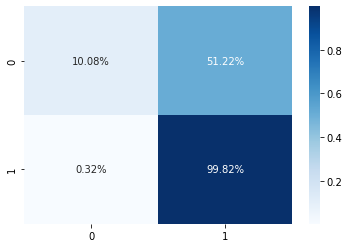

In [ ]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
import seaborn as sns

sns.heatmap(c_matrix/np.sum(c_matrix,axis=1), annot=True, 
            fmt='.2%', cmap='Blues');

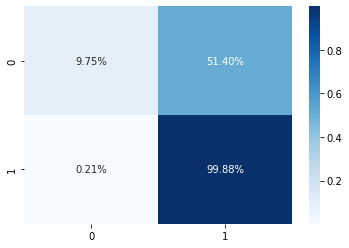

In [ ]:
y_test

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

              precision    recall  f1-score   support

           0       0.10      0.97      0.18        97
           1       1.00      0.66      0.80      2474

    accuracy                           0.67      2571
   macro avg       0.55      0.81      0.49      2571
weighted avg       0.96      0.67      0.77      2571

Balanced Accuracy :  0.5494593830606692


<Figure size 432x288 with 0 Axes>

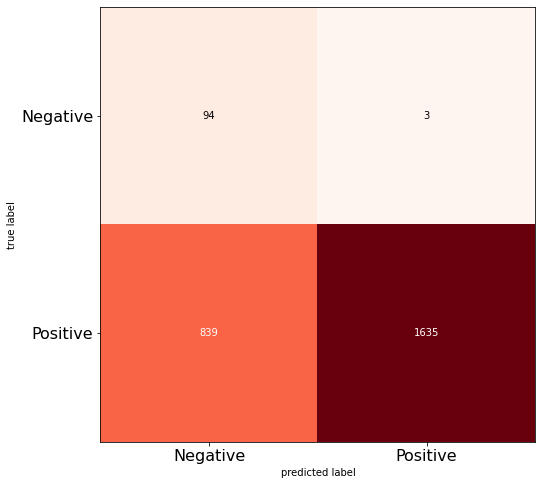

In [ ]:
from sklearn.metrics import roc_curve, auc

model_Evaluate(rfc)

RecursionError: maximum recursion depth exceeded while getting the repr of an object

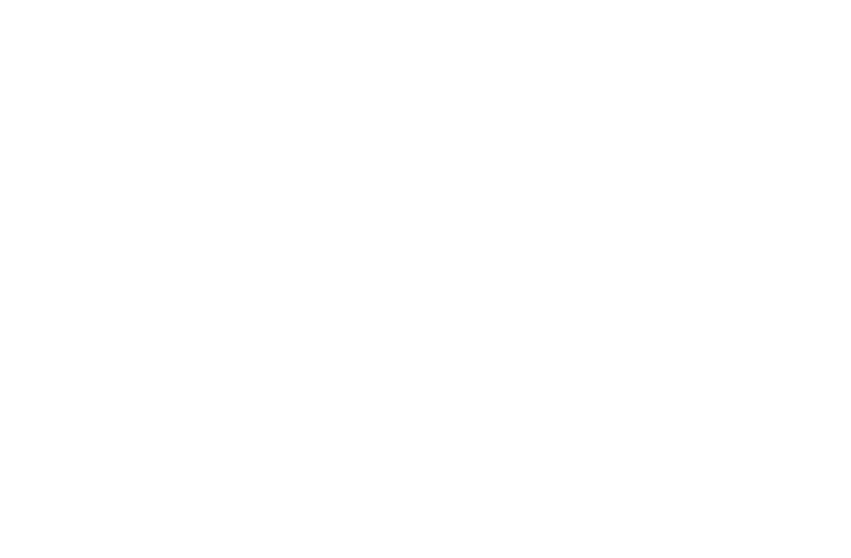

In [ ]:
from sklearn import tree

plt.figure(figsize=(15,10))
for i in range(len(rfc.estimators_)):
    tree.plot_tree(rfc.estimators_[i],filled=True)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
accuracy_score(y_test,rfc.predict(X_test))

0.6717230649552703

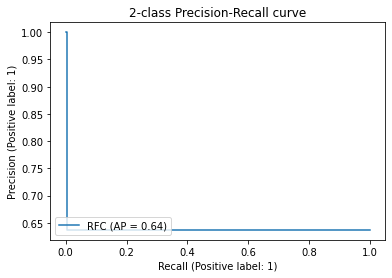

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    rfc, X_test, y_test, name="RFC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
y_pred_proba = rfc.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:,1]))

0.5021367521367521


In [ ]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0,1])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
   processed_features, labels, test_size=0.2, random_state=0
)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(
         make_pipeline(LinearSVC(random_state=0)))
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

ValueError: y should be a 1d array, got an array of shape (2571, 2) instead.

#### __AdaBoostClassifier__

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(base_estimator = estimator,
                             n_estimators=200,
                             learning_rate=0.5,
                             random_state=42)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6390509529366005

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [ ]:
sns.barplot(x=classes, y=ada_clf.feature_importances_);

NameError: name 'classes' is not defined

#### __Gradient Boosting Classifier__

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbct = GradientBoostingClassifier(max_depth=2,
                                 n_estimators=100,
                                 learning_rate=1.0,
                                 random_state=42)
gbct.fit(X_train, y_train)


y_pred_gbct = gbct.predict(X_test)
accuracy_score(y_test, y_pred_gbct)

0.6390509529366005

NameError: name 'tree_reg1' is not defined

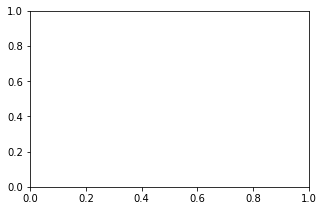

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

#### __XGBoost Classifier__

In [ ]:
import xgboost

xgb_clas = xgboost.XGBRFClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 eval_metric='auc')

xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
accuracy_score(y_test, y_pred)

C:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6374951380785686

Voting CLassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

'''
Por defecto coge soft voting, si pueden todos los clasificadores.
En el caso del SVM tiene que realizar una validación cruzada ya que
no soporta el predict_proba()
'''

log_clf = LogisticRegression(random_state=42) # Mezcla los datos
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42) # Se usa en combinación con otro arg
svm_clf = SVC(gamma="scale", random_state=42)

estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard')

In [ ]:
# Train the model
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.6390509529366005
RandomForestClassifier 0.6725009723842863
SVC 0.6725009723842863
VotingClassifier 0.6725009723842863


In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # PROBABILITY = TRUE

estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)]

soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Train the model
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.6390509529366005
RandomForestClassifier 0.6725009723842863
SVC 0.6725009723842863
VotingClassifier 0.6725009723842863


[[  94  839]
 [   3 1635]]


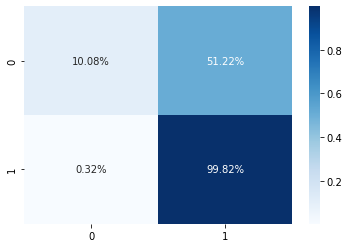

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

sns.heatmap(c_matrix/np.sum(c_matrix,axis=1), annot=True, 
            fmt='.2%', cmap='Blues');

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(max_depth=3,random_state=42)

bag_clf = BaggingClassifier(
    base_estimator = estimator,
    n_estimators=500, # Cantidad de árboles
    max_samples=100, # Muestras utilizadas en boostrapping
    bootstrap=True, # Usamos boostrapping
    # max_features = 3 # Features que utiliza en el boostrapping. Cuanto más bajo, mejor generalizará y menos overfitting
    random_state=42)


bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6371061843640606

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.6721120186697783
